Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.3432033055362013
Validation Accuracy: 0.9034053460270963
Epoch 2, Loss: 0.23482668514464025
Validation Accuracy: 0.9102892713291835
Epoch 3, Loss: 0.15455865141029698
Validation Accuracy: 0.9105089710728671
Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.91      0.89      1668
     Neutral       0.53      0.48      0.50       498
    Positive       0.96      0.96      0.96      4561

    accuracy                           0.91      6727
   macro avg       0.79      0.78      0.78      6727
weighted avg       0.91      0.91      0.91      6727



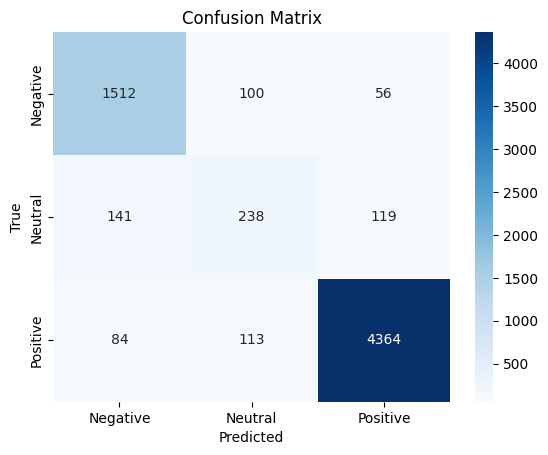

Model and tokenizer saved to /content/drive/My Drive/xlnet_sentiment_model


In [1]:
from google.colab import drive
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset (update file path if necessary)
file_path = '/content/20191226-reviews.csv'  # Update this path
data = pd.read_csv(file_path)

# Preprocessing
data = data.dropna(subset=['title', 'body', 'rating'])
data['ReviewText'] = data['title'] + ' ' + data['body']
data['Sentiment'] = data['rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))
data = data[['ReviewText', 'Sentiment']]

# Train, test, validation split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data['ReviewText'], data['Sentiment'], test_size=0.3, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.33, random_state=42
)

# Tokenizer setup
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding['token_type_ids'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and data loaders
train_dataset = ReviewDataset(train_texts, train_labels, tokenizer)
val_dataset = ReviewDataset(val_texts, val_labels, tokenizer)
test_dataset = ReviewDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3
num_training_steps = epochs * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

# Loss function
loss_fn = CrossEntropyLoss()

# Training loop
def train_model():
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

        # Validation
        model.eval()
        val_preds, val_labels_all = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                val_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
                val_labels_all.extend(labels.cpu().numpy())
        print("Validation Accuracy:", accuracy_score(val_labels_all, val_preds))

train_model()

# Testing
model.eval()
test_preds, test_labels_all = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        test_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(test_labels_all, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(test_labels_all, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save model and tokenizer
output_dir = "/content/drive/My Drive/xlnet_sentiment_model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")
